# NYC Taxi fares. Time series prediction

## Imports

In [1]:
from plotly import express as px
from pmdarima.arima import auto_arima, ARIMA
import pandas as pd
import numpy as np
from datetime import timedelta

from data import df

## Functions

### `analyse_params`

In [2]:
def analyse_params(model:ARIMA, name:str) -> None:
    
    params = model.params()
    params = params[~params.index.str.contains('sigma')]

    AR_params = [param for param in params.index if 'ar' in param]
    MA_params = [param for param in params.index if 'ma.' in param]
    num_X_params = len(params) - len(AR_params) - len(MA_params)

    print(f'{name.title()} model params')
    print('----------------------------------------')
    print(f'{len(params) - num_X_params} final parameters ({len(AR_params)} autorregresive, \
{len(MA_params)} moving average), {num_X_params} exogenous variable(s)')

### `predict`

In [3]:
def predict(model:ARIMA, X:pd.DataFrame) -> list:
    
    if X is not None:
        fc, conf_int = model.predict(
            n_periods = 100,
            X = X,
            return_conf_int = True
        )
        
    else:
        fc, conf_int = model.predict(n_periods = 100, return_conf_int = True)
        
    fc = pd.DataFrame(data = fc.values, index = fc.index, columns = ['prediction'])
    
    print(f'Prediction generated correctly. {len(fc)} predictions made')
    print('----------------------------------------')
    print(fc.head())
    
    return [fc, conf_int]

## DataFrame description, info and numerical description

In [4]:
df.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
tpep_pickup_datetime,,,,,,,,,,,,
2023-01-01,113974.0,395174.12,1678504.53,89706.18,37044.20,276684.88,55280.72,75127.2,2347474.51,160070.0,10362.50,0.0
2023-01-02,96851.0,298874.57,1444484.02,83088.86,31814.76,237793.89,56891.01,64211.2,2033444.79,139790.0,12468.75,0.0
2023-01-03,115287.0,348516.38,1715578.34,147568.36,41749.00,292241.73,57155.09,84017.4,2488095.37,183855.0,13480.00,0.0
2023-01-04,126389.0,336227.96,1804562.62,168187.22,46444.60,314904.88,51852.18,93276.9,2645252.00,208007.5,11840.00,0.0
2023-01-05,133863.0,357666.94,1854466.88,173475.32,49401.30,329524.08,51474.70,99253.3,2734582.83,223505.0,11030.00,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2023-01-01 to 2023-12-30
Freq: D
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_count        364 non-null    float64
 1   trip_distance          364 non-null    float64
 2   fare_amount            364 non-null    float64
 3   extra                  364 non-null    float64
 4   mta_tax                364 non-null    float64
 5   tip_amount             364 non-null    float64
 6   tolls_amount           364 non-null    float64
 7   improvement_surcharge  364 non-null    float64
 8   total_amount           364 non-null    float64
 9   congestion_surcharge   364 non-null    float64
 10  airport_fee            364 non-null    float64
 11  Airport_fee            364 non-null    float64
dtypes: float64(12)
memory usage: 37.0 KB


In [6]:
df.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
count,364.000000,364.000000,3.640000e+02,364.000000,364.000000,364.000000,364.000000,364.000000,3.640000e+02,364.000000,364.000000,364.000000
mean,139011.409341,429578.286593,2.050621e+06,163560.797253,51009.041181,370051.131456,61954.702335,102879.993681,2.989829e+06,229778.518544,883.753434,13319.150275
std,22756.479747,102641.903466,3.578548e+05,46796.964501,8990.401729,71708.026545,11948.419380,18062.524130,5.322748e+05,42506.079162,2934.308900,5233.192804
min,28.000000,41140.380000,1.002502e+05,300.250000,2300.500000,10073.810000,2475.920000,4613.400000,1.326503e+05,22.500000,0.000000,0.000000
25%,127646.000000,370679.900000,1.843082e+06,121325.172500,45927.275000,327743.920000,54686.285000,92798.250000,2.689060e+06,205430.625000,0.000000,11228.437500
50%,140456.500000,413498.490000,2.076759e+06,175177.225000,51980.150000,374557.055000,62334.085000,105124.950000,3.018451e+06,235515.000000,0.000000,14946.750000
75%,153270.000000,471705.007500,2.276029e+06,201744.067500,57321.350000,413766.172500,70415.762500,115370.250000,3.310928e+06,259181.250000,0.000000,16826.687500
max,188387.000000,846786.410000,2.998468e+06,243137.100000,70438.500000,543560.910000,83622.660000,142158.200000,4.352100e+06,308217.500000,13480.000000,23483.250000


## Fare amount distribution

In [7]:
fig = px.line(x = df.index, y = df['fare_amount'])

fig.update_layout(title = 'Fare amount by date')
fig.update_yaxes(visible = False)
fig.update_xaxes(title = '')

fig.show()

## ARIMA model generation

### Model

In [8]:
model = auto_arima(
    y = df['fare_amount'],
    X = df['passenger_count'].values.reshape(-1, 1),
    seasonal = False,
    d = 1
)

analyse_params(model = model, name = 'fare amount')
print()
model.summary()

Fare Amount model params
----------------------------------------
2 final parameters (0 autorregresive, 2 moving average), 1 exogenous variable(s)



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -4761.956
Date:                Tue, 11 Jun 2024   AIC                           9531.913
Time:                        23:09:20   BIC                           9547.490
Sample:                    01-01-2023   HQIC                          9538.105
                         - 12-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            12.4590      0.309     40.327      0.000      11.853      13.065
ma.L1         -0.3075      0.043     -7.141      0.000      -0.392      -0.223
ma.L2         -0.5693      0.041    -14.033      0.000      -0.649      -0.490
sigma2      1.572e+10    1.1e-11   1.42e+21      0.000    1.57e+10    1.57e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 9.91
Prob(Q):                              0.79   Prob(JB):                         0.01
Heteroskedasticity (H):               2.01   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.25e+37. Standard errors may be unstable.
"""

### Residual distribution diagnostics

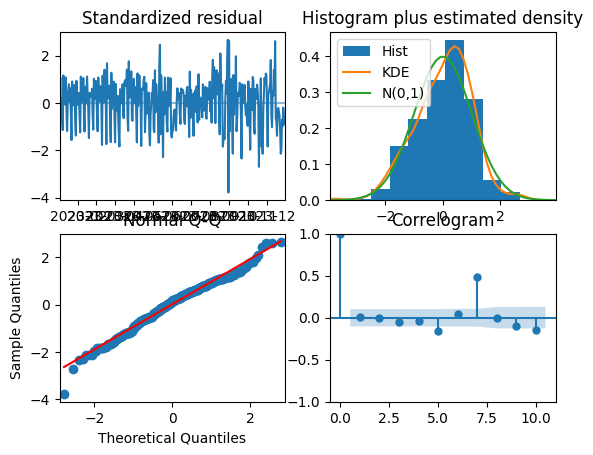

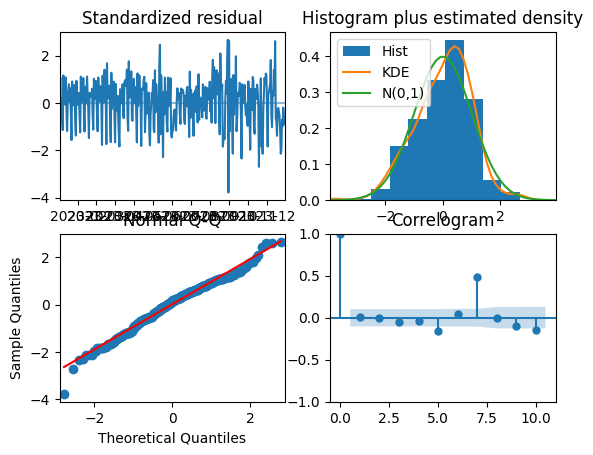

In [9]:
model.plot_diagnostics()

## Time series prediction

### Exogenous model

In [10]:
px.line(x = df.index, y = df['passenger_count'])

In [11]:
ex_model = auto_arima(
    y = df['passenger_count'],
    seasonal = False,
    d = 1
)

analyse_params(model = ex_model, name = 'passenger count')
ex_model.summary()

Passenger Count model params
----------------------------------------
3 final parameters (2 autorregresive, 1 moving average), 0 exogenous variable(s)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -4016.625
Date:                Tue, 11 Jun 2024   AIC                           8041.251
Time:                        23:09:22   BIC                           8056.828
Sample:                    01-01-2023   HQIC                          8047.443
                         - 12-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8752      0.044     20.020      0.000       0.790       0.961
ar.L2         -0.2351      0.043     -5.496      0.000      -0.319      -0.151
ma.L1         -0.9495      0.025    -38.303      0.000      -0.998      -0.901
sigma2      2.583e+08   5.57e-11   4.63e+18      0.000    2.58e+08    2.58e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):               334.89
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.26e+34. Standard errors may be unstable.
"""

### Residual distribution diagnostics

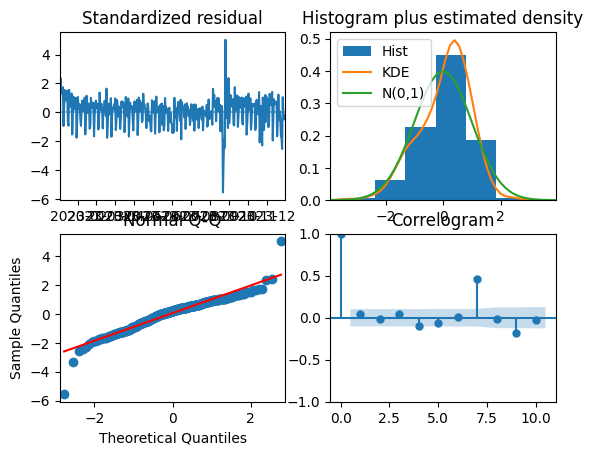

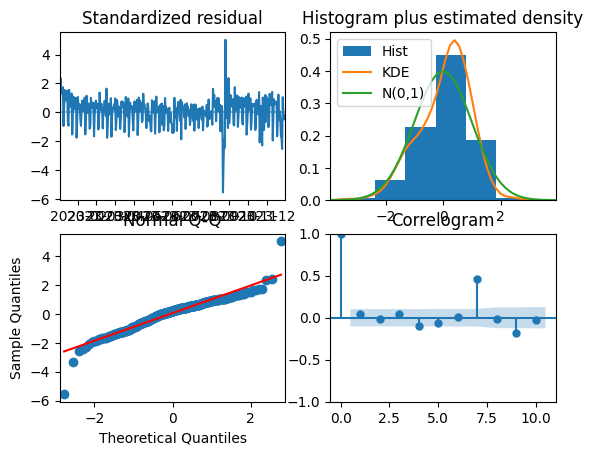

In [12]:
ex_model.plot_diagnostics()

## Predictions

### Exogenous

In [13]:
imputed_X, ex_conf_int = predict(model = ex_model, X = False)

Prediction generated correctly. 100 predictions made
----------------------------------------
               prediction
2023-12-31  128915.167025
2024-01-01  133203.712491
2024-01-02  136004.084203
2024-01-03  137446.690036
2024-01-04  138050.869097


### Target

In [14]:
fc, conf_int = predict(model = model, X = imputed_X)

Prediction generated correctly. 100 predictions made
----------------------------------------
              prediction
2023-12-31  1.809163e+06
2024-01-01  1.926947e+06
2024-01-02  1.961837e+06
2024-01-03  1.979810e+06
2024-01-04  1.987338e+06


In [15]:
fig.update_traces(showlegend = True, name = 'observed')
fig.add_scatter(x = fc.index, y = fc['prediction'], name = 'predicted')

conf_int_px = px.line(
    x = fc.index,
    y = [conf_int[:, 0], conf_int[:, 1]],
    color_discrete_sequence = ['rgba(0, 0, 0, 0)' for _ in range(len(conf_int))]
    )

conf_int_px.update_traces(fill = 'tonexty', fillcolor = 'rgba(0, 39, 180, 0.21)', showlegend = False)
for trace in conf_int_px.data:
    fig.add_trace(trace)

fig.show()